In [ ]:
!curl https://data.deepai.org/mnist.zip -o mnist.zip
!unzip mnist.zip -d mnist/
!rm mnist.zip
!gunzip mnist -r

In [231]:
!ls mnist

t10k-images-idx3-ubyte  train-images-idx3-ubyte
t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [3]:
import torch
torch.set_printoptions(sci_mode=False)
device = 'cpu'

In [4]:
import numpy as np

def load_mnist_data(test=False):
    if(test):
        f_images = open('mnist/t10k-images-idx3-ubyte','rb')
        f_labels = open('mnist/t10k-labels-idx1-ubyte','rb')
    else:
        f_images = open('mnist/train-images-idx3-ubyte','rb')
        f_labels = open('mnist/train-labels-idx1-ubyte','rb')
        
    # skip bullshit start
    f_images.seek(16)
    f_labels.seek(8)
    
    # read whole file
    buf_images = f_images.read()
    buf_labels = f_labels.read()
    
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(-1, 1, 28, 28) / 256
    
    labels = np.frombuffer(buf_labels, dtype=np.uint8)
    labels_one_hot = np.zeros((labels.shape[0], 10))
    labels_one_hot[np.arange(labels.size), labels] = 1
    
    return images, labels

def sample_batch(X, Y, batch_size=32):
    length = len(Y)
    idx = np.random.choice(np.arange(0, length), size=(batch_size), replace=False)
    
    return X[idx], Y[idx]

## USAGE EXAMPLE:
#  X, Y = load_mnist_data(test=False)
#  x, y = sample_batch(X, Y)

In [5]:
# Usage of BLOCKS:
# - BLOCK A * 1
# - BLOCK B * 7

# BLOCK:
# - Cross Attention with only 1 head (Q from latent, KV from input)
# - Latent Transformer with X blocks

In [5]:
def checker_board(d_model):
    half = (d_model) // 2
    texture = torch.cat([
        torch.ones((half, 1)),
        torch.zeros((half, 1))
    ], dim=1).view((-1,))
    
    return texture

def pos_embedding(x):
        # x: (pos, n, i)
        
        length = x.shape[0]
        batch_size = x.shape[1]
        d_model = x.shape[2]

        i = torch.arange(0, d_model).view((1, 1, -1)).expand(length, -1, d_model).to(device).float()
        pos = torch.arange(0, length).view((-1, 1, 1)).expand(length, -1, d_model).to(device).float()
        
        z = pos / 10000 ** (i / d_model)
        
        sin = torch.sin(z)
        cos = torch.cos(z)
        
        sin_mask = checker_board(d_model).to(device)
        cos_mask = -sin_mask + 1
                
        pe = (sin_mask * sin) + (cos_mask * cos)
        pe = pe.expand(length, batch_size, d_model)
        
        return x + pe
    
#pos_embedding(torch.ones((16, 1, 8)))

In [21]:
import torch
from torch import nn
import torch.nn.functional as F
from matplotlib.pyplot import imshow

class AttentionBlock(nn.Module):
    def __init__(self, d_model, heads, dropout=0.25):
        super(AttentionBlock, self).__init__()
        
        self.layer_norm1 = nn.LayerNorm([d_model])
        self.attention = nn.MultiheadAttention(
            d_model,
            heads,
            dropout=0.0,
            bias=True,
            add_bias_kv=True,
        )
        #self.dropout = nn.Dropout(p=dropout)
        #self.linear1 = nn.Linear(d_model, d_model)
        
        #self.layer_norm2 = nn.LayerNorm(d_model)
        self.linear2 = nn.Linear(d_model, d_model)
        #self.linear3 = nn.Linear(d_model, d_model)
        
    def forward(self, x, z_input):
        x = self.layer_norm1(x)
        z = self.layer_norm1(z_input)
        z, _ = self.attention(z, x, x)
        
        #z = self.dropout(z)
        #z = self.linear1(z)
        
        #z = self.layer_norm2(z)
        z = self.linear2(z)
        z = F.gelu(z)
        #z = self.dropout(z)
        #z = self.linear3(z)
        
        return z + z_input

class PerceiverBlock(nn.Module):
    def __init__(self, d_model, latent_blocks):
        super(PerceiverBlock, self).__init__()
        
        self.cross_attention = AttentionBlock(d_model, heads=1)
        self.latent_attentions = nn.ModuleList([
            AttentionBlock(d_model, heads=4) for _ in range(latent_blocks)
        ])
        
    def forward(self, x, z):
        z = self.cross_attention(x, z)
        #for latent_attention in self.latent_attentions:
        #    z = latent_attention(z, z)
        return z

class Repeater(nn.Module):
    def __init__(self, module, repeats=1):
        super(Repeater, self).__init__()
        
        self.repeats = repeats
        self.module = module
    
    def forward(self, x, z):
        for _ in range(self.repeats):
            z = self.module(x, z)
        return z
    
class Perceiver(nn.Module):
    def __init__(self, output_size, latents=16, d_model=8, input_channels=1):
        super(Perceiver, self).__init__()

        self.init_latent = nn.Parameter(torch.rand((latents, d_model)))
        self.embedding = nn.Conv1d(input_channels, d_model, 1)
        
        self.block1 = Repeater(PerceiverBlock(d_model, latent_blocks=2), repeats=1)
        self.block2 = Repeater(PerceiverBlock(d_model, latent_blocks=2), repeats=2)
        self.block3 = Repeater(PerceiverBlock(d_model, latent_blocks=2), repeats=2)
        
        self.linear1 = nn.Linear(d_model, d_model)
        self.linear2 = nn.Linear(d_model, output_size)   
        
    def forward(self, x):
        # Transform our X (input)     
        # x.shape = (batch_size, channels, width, height)
        x = x.view((x.shape[0], x.shape[1], -1))
        # x.shape = (batch_size, channels, pixels)
        
        x = self.embedding(x)
        # x.shape = (batch_size, d_model, pixels)
        x = x.permute(2, 0, 1)
        # x.shape (pixels, batch_size, d_model)
        
        #print(x.shape)
        
        x = pos_embedding(x)
        
        #imshow(x.detach().numpy() * 255)
        
               
        #raise False
               
        # Transform our Z (latent)
        # z.shape = (latents, d_model)
        z = self.init_latent.unsqueeze(1)
        # z.shape = (latents, 1, d_model)
        z = z.expand(-1, x.shape[1], -1)
        # z.shape = (latents, batch_size, d_model)
        
        #print('0', z)
        z = self.block1(x, z)
        #print('1', z)
        z = self.block2(x, z)
        z = self.block3(x, z)
        #print('2', z)
        
        z = self.linear1(z)
        z = z.mean(dim=0)
        z = self.linear2(z)
        
        return z
    
model = Perceiver(output_size=10)

In [22]:
def test(model):
    with torch.no_grad():
        X_test, Y_test = load_mnist_data(test=True)
        X_LENGTH = len(X_test)
        BATCH_SIZE = 500
        DEVICE = 'cpu'

        correct = 0
        total = 0

        t = range(X_LENGTH // BATCH_SIZE)
        for i in t:
            x = torch.from_numpy(X_test[i * BATCH_SIZE:(i+1) * BATCH_SIZE]).float().to(DEVICE)
            y = torch.from_numpy(Y_test[i * BATCH_SIZE:(i+1) * BATCH_SIZE]).long().to(DEVICE)

            y_ = model(x).argmax(dim=-1)

            total += len(y_)
            correct += (y_ == y).sum().item()

        return correct / total
    
test(model)

0.101

In [23]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1, verbose=False)


In [ ]:
from tqdm import trange

X, Y = load_mnist_data(test=False)
X_LENGTH = len(X)
EPOCHS = 10
BATCH_SIZE = 32
DEVICE = 'cpu'

for epoch in range(EPOCHS):
    print('EPOCH', epoch, '[LEARNING RATE: ' + str(optimizer.param_groups[0]['lr']) + ']')
    if(epoch <= -1):
        scheduler.step()
        continue
        
    t = trange(X_LENGTH // BATCH_SIZE)
    for _ in t:
        optimizer.zero_grad()
        
        x, y = sample_batch(X, Y, BATCH_SIZE)
        x = torch.from_numpy(x).float().to(DEVICE)
        y = torch.from_numpy(y).long().to(DEVICE)
        
        y_ = model(x)
        loss = nn.CrossEntropyLoss()(y_, y)
        
        loss.backward()
        optimizer.step()
        
        t.set_description(str(loss.item())[0:5])
    print('[ACCURACY: ' + str(test(model)) + ']')
    scheduler.step()

2.295:   0%|          | 2/1875 [00:00<02:11, 14.20it/s]

EPOCH 0 [LEARNING RATE: 0.01]


1.184:   0%|          | 2/1875 [00:00<02:14, 13.91it/s]

[ACCURACY: 0.6203]
EPOCH 1 [LEARNING RATE: 0.01]


1.314:   0%|          | 2/1875 [00:00<02:25, 12.84it/s]

[ACCURACY: 0.7496]
EPOCH 2 [LEARNING RATE: 0.01]


0.406:  57%|█████▋    | 1062/1875 [01:10<00:52, 15.51it/s]

In [54]:
model(torch.tensor([0.0,1.0]).view((1,1,1,2)))

tensor([[ 0.0139, -0.1574,  0.5565,  0.2240, -0.1797, -0.2278,  0.2837,  0.0194,
         -0.0857, -0.2254]], grad_fn=<AddmmBackward>)

In [ ]:
from tqdm import trange

X, Y = load_mnist_data(test=False)
X_LENGTH = len(X)
EPOCHS = 10
BATCH_SIZE = 16
DEVICE = 'cpu'

for epoch in range(1):
    for _ in range(10000):
        optimizer.zero_grad()
        
        x = torch.round(torch.rand((BATCH_SIZE, 1, 1, 2)))
        #print(x)
        y = torch.prod(x, dim=3)
        
        y_ = model(x)
        loss = nn.MSELoss()(y_, y)
        
        loss.backward()
        optimizer.step()
        
        if(_ % 2 == 0):
            print(loss)

In [30]:
model.init_latent

Parameter containing:
tensor([[ 0.4986,  0.8630,  0.2013,  0.3818,  0.7835,  0.8413,  0.1154,  0.8566,
          0.5011,  0.8450,  0.5101,  0.7268,  0.8154,  0.8392,  0.7373,  0.1881],
        [ 0.1795,  0.6890,  0.4758,  0.4538,  0.9585,  0.7544,  0.7605,  0.1170,
          1.0515,  0.6272,  0.6923,  0.1439,  0.3151,  1.0141,  0.6098,  0.4420],
        [ 0.3529,  0.4465,  0.5990,  0.9882,  0.6056,  0.4392,  0.9566,  0.6223,
          0.5232,  0.4905,  0.3253, -0.0067,  0.7748,  0.0487,  0.4261,  0.0225],
        [ 0.0740,  0.6972, -0.0544,  0.7206,  0.3876,  0.2320,  0.5455,  0.1779,
          0.0595,  0.5255,  0.9128,  0.9452,  0.0945,  0.7067,  0.3905,  0.5256]],
       requires_grad=True)

In [28]:
model.init_latent

Parameter containing:
tensor([[ 0.5033,  0.8624,  0.2247,  0.3716,  0.7758,  0.8854,  0.1261,  0.8666,
          0.5142,  0.8339,  0.4869,  0.7186,  0.8476,  0.8083,  0.7432,  0.1994],
        [ 0.1934,  0.6917,  0.4956,  0.4365,  0.9429,  0.8464,  0.7469,  0.1681,
          1.0636,  0.6288,  0.6425,  0.1440,  0.3613,  0.9735,  0.6283,  0.4511],
        [ 0.3527,  0.4468,  0.6180,  0.9728,  0.5977,  0.4942,  0.9471,  0.6464,
          0.5252,  0.5152,  0.2958, -0.0106,  0.8017,  0.0276,  0.4370,  0.0278],
        [ 0.0616,  0.7055, -0.0422,  0.7026,  0.3713,  0.2474,  0.5271,  0.2261,
          0.0699,  0.5331,  0.9309,  0.9730,  0.1046,  0.6948,  0.3938,  0.5380]],
       requires_grad=True)

In [ ]:
torch.save(model.state_dict(),'model1')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



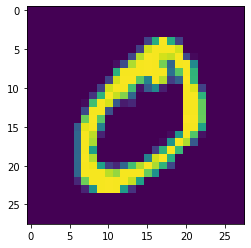

In [163]:
from matplotlib.pyplot import imshow

imshow(data[1])